In [1]:
# Import Libs
import time
init_time = time.time()

import os
import pickle
import numpy as np
import ROOT

from functions import HistogramFunctions,AuxiliarFunctions,FigureFunctions,FitFunctions,rootnotes

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 20

current_time = time.time()
print 'Time to import libraries: %1.3f seconds'%(current_time-init_time)


Time to import libraries: 1.092 seconds


In [2]:
# Read Data

from keras.utils import np_utils

init_time = time.time()

from sklearn import datasets

output = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/DataFiles"

# import some data to play with

signal = np.load(output+"/"+"lvbb125Matrix.npy")[0:5000,[0,7,11,12,19,23]]
trgt_signal = np.ones(signal.shape[0])

all_signal = np.load(output+"/"+"lvbb125Matrix.npy")


ZZ = np.load(output+"/"+"ZZMatrix.npy")[0:5000,[0,7,11,12,19,23]]
trgt_ZZ = 0.0*np.ones(ZZ.shape[0])

all_ZZ = np.load(output+"/"+"ZZMatrix.npy")

TTbar = np.load(output+"/"+"TTbarMatrix.npy")
trgt_TTbar = -1.0*np.ones(TTbar.shape[0])

background=ZZ
trgt_bkg=trgt_ZZ

all_background = all_ZZ 

data_colors = ['b','r']
data_labels = ['signal','background']

data=np.append(signal,background,axis=0)
trgt=np.append(trgt_signal,trgt_bkg,axis=0)

all_data=np.append(all_signal,all_background,axis=0)

sparse_trgt = np_utils.to_categorical(trgt)

# for classification -> target max sparse
#trgt_sparse = np_utils.to_categorical(trgt_sinal)

current_time = time.time()
#print 'Time to import data: %1.3f seconds'%(current_time-init_time)
print "Sinal", signal.shape
print "ZZ", ZZ.shape
print data.shape
print trgt.shape
print sparse_trgt.shape
print len(data[0])
print range(len(data[0]))


Using Theano backend.


Sinal (5000, 6)
ZZ (5000, 6)
(10000, 6)
(10000,)
(10000, 2)
6
[0, 1, 2, 3, 4, 5]


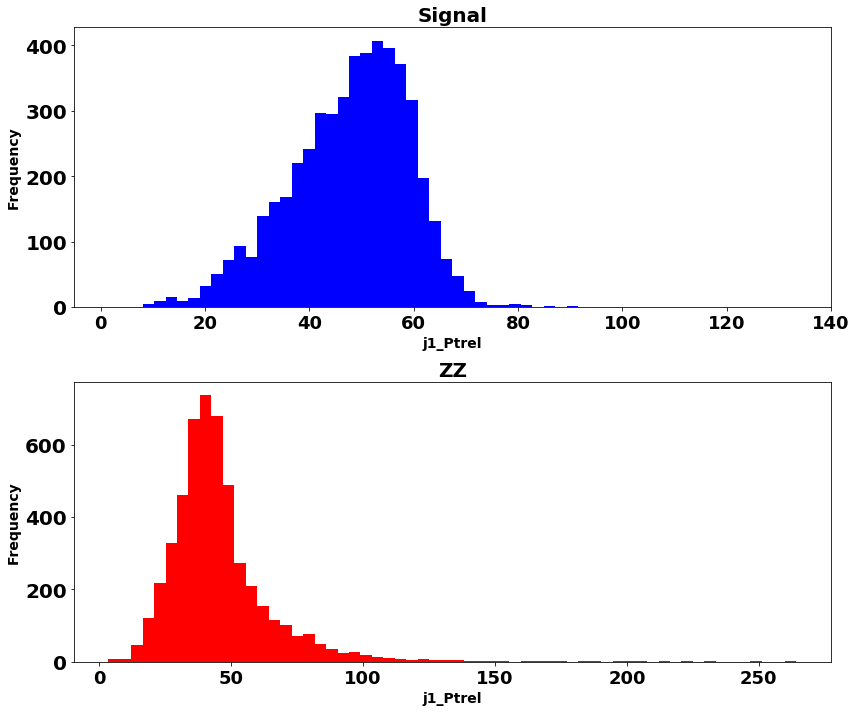

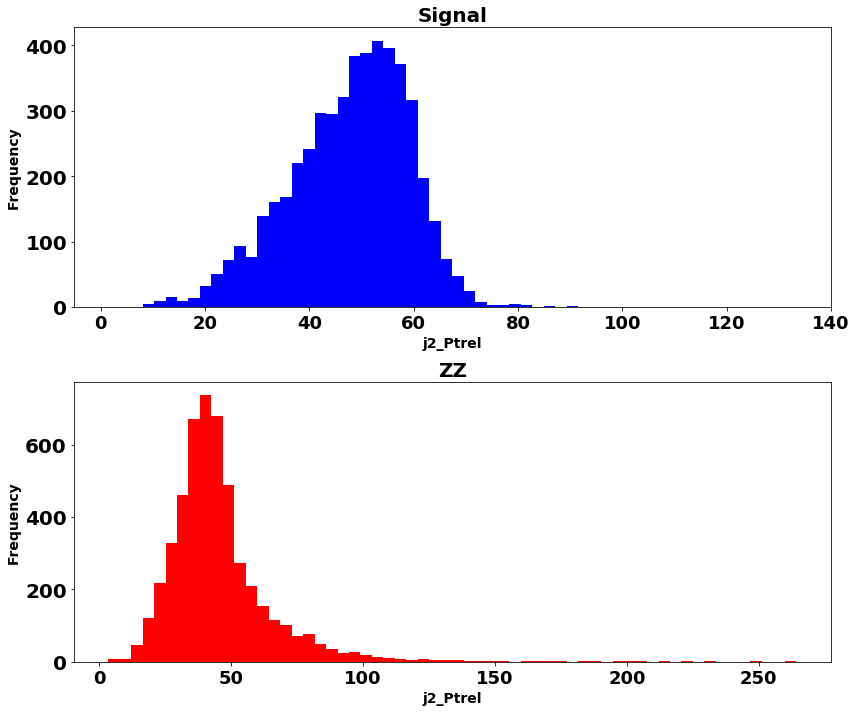

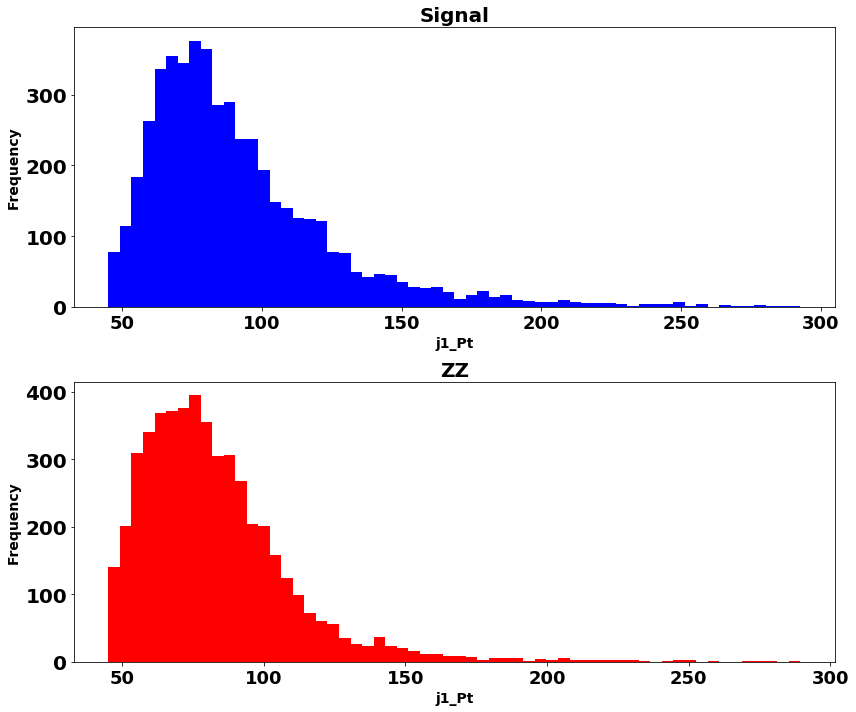

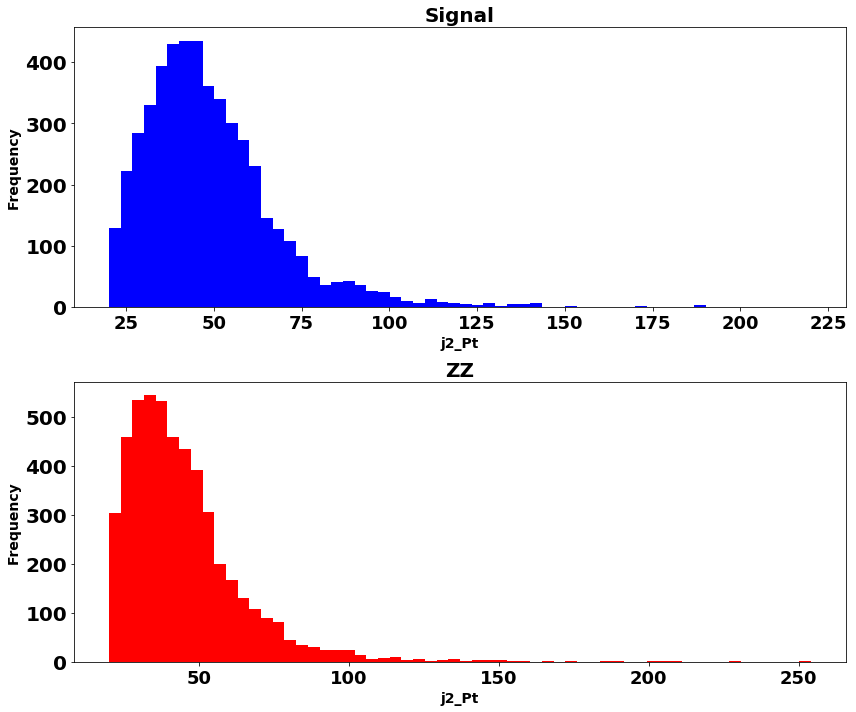

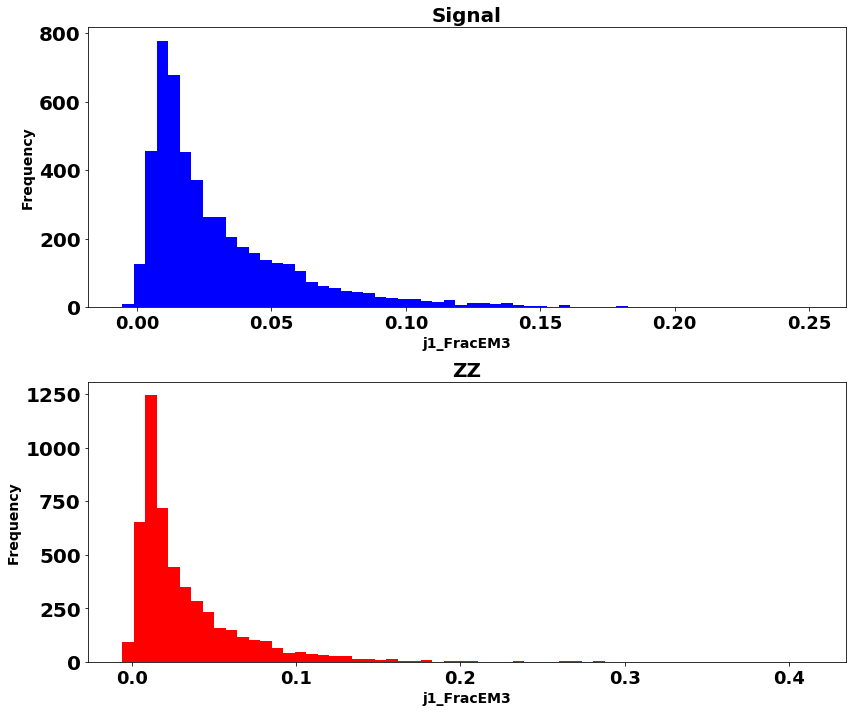

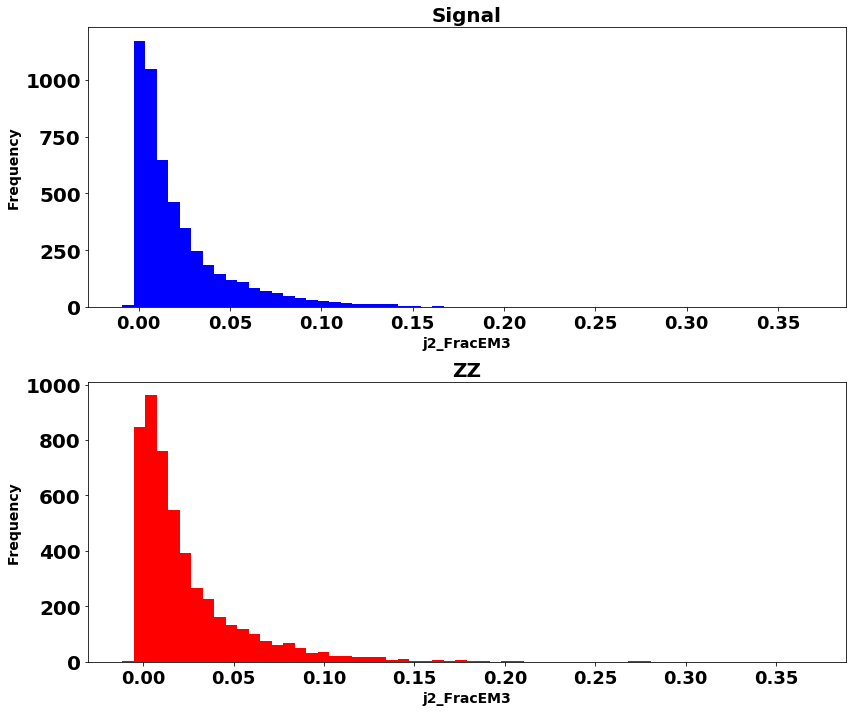

In [4]:
import matplotlib.pyplot as plt

save_point = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/"

#variables = "j1_FracEM3,j1_FracTile0,j1_TrkWidth,j1_EMF,j1_JVF,j1_NTrk,j1_SumPtTrk,j1_Pt,j1_Eta,j1_Phi,j1_E,j1_PtRel,j2_FracEM3,j2_FracTile0,j2_TrkWidth,j2_EMF,j2_JVF,j2_NTrk,j2_SumPtTrk,j2_Pt,j2_Eta,j2_Phi,j2_E,j2_PtRel"
variables = "j1_Ptrel,j2_Ptrel,j1_Pt,j2_Pt,j1_FracEM3,j2_FracEM3"


for variable,i in zip(variables.split(","),range(len(data[0]))):
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    ax1.hist(signal[:,i],60,color='b')
    ax2.hist(ZZ[:,i],60,color='r')
    
    ax1.set_title('Signal', size=20, weight='bold')
    ax1.set_xlabel(variable, size=14, weight='bold')
    ax1.set_ylabel("Frequency", size=14, weight='bold')
    #ax1.savefig(save_point+'/'+'Output_TTbar_'+str(lr)+'_'+str(decay)+'_'+str(momentum)+'.pdf')
    
    ax2.set_title('ZZ', size=20, weight='bold')
    ax2.set_xlabel(variable,size=14, weight='bold')
    ax2.set_ylabel("Frequency",size=14, weight='bold')
    
    fig.tight_layout()
    fig.savefig(save_point+'/'+variable)

-0.00763757012982


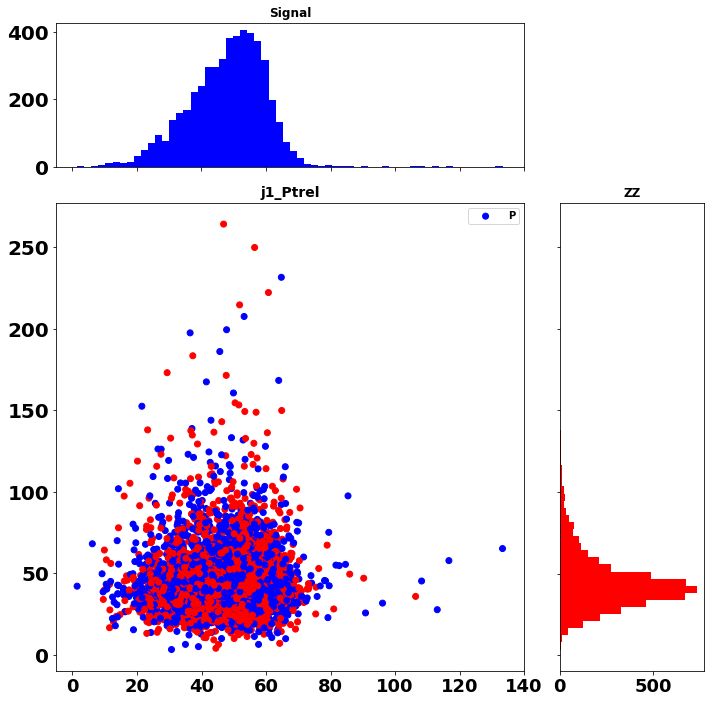

-0.00763757012982


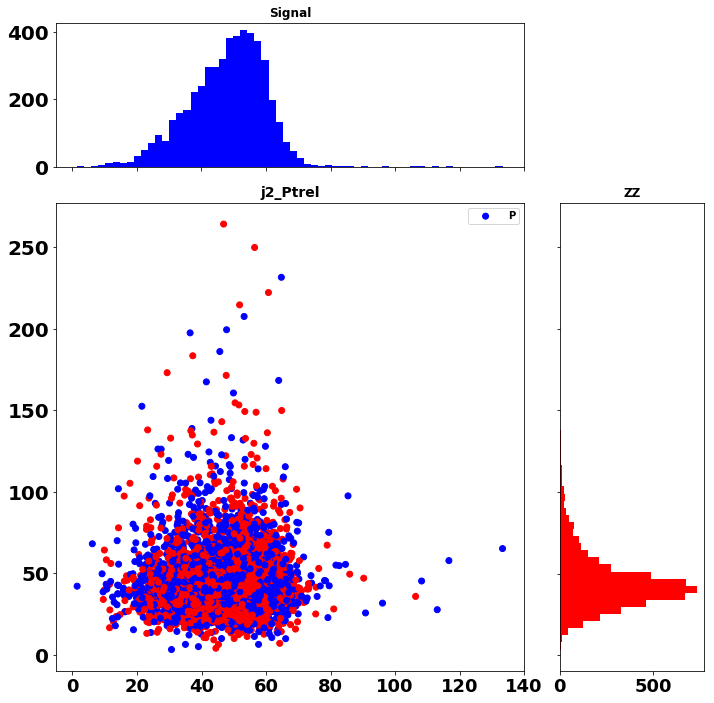

0.00366397031647


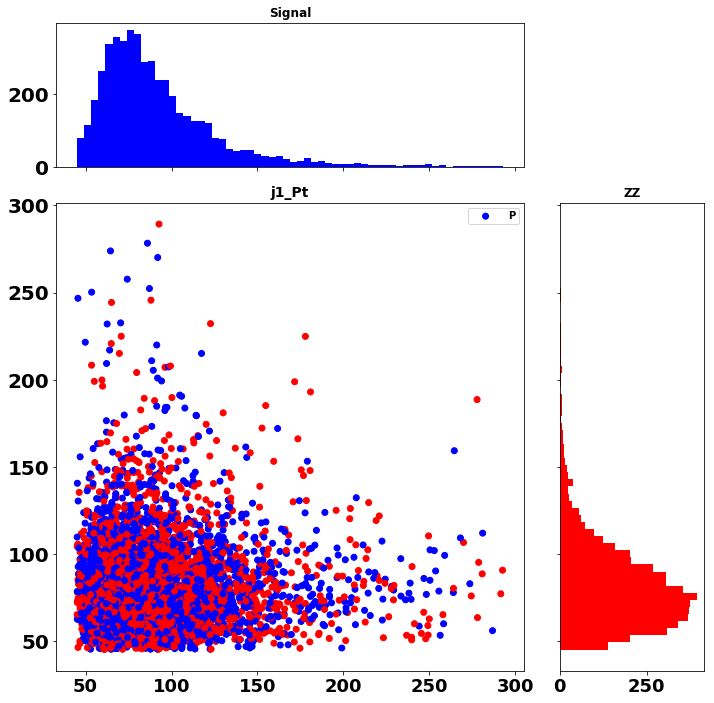

0.0109578687626


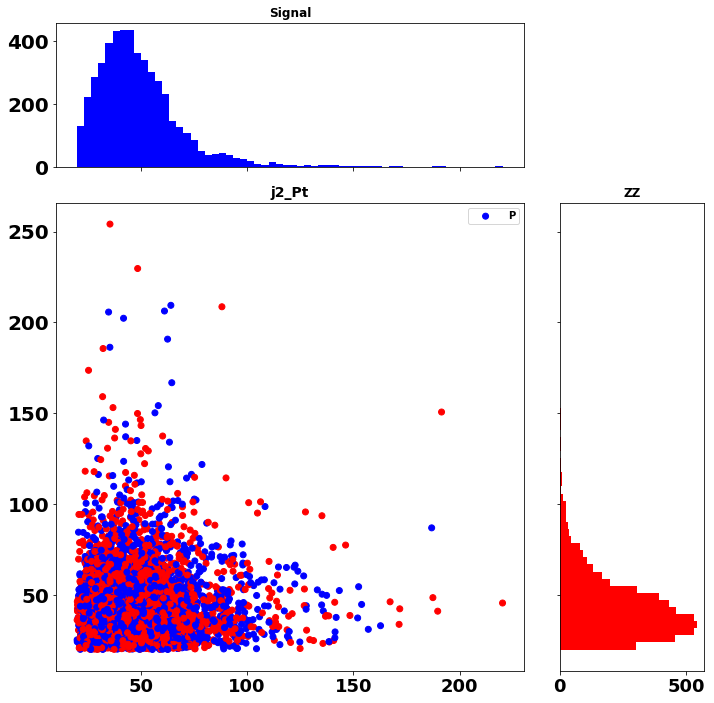

0.0194915932331


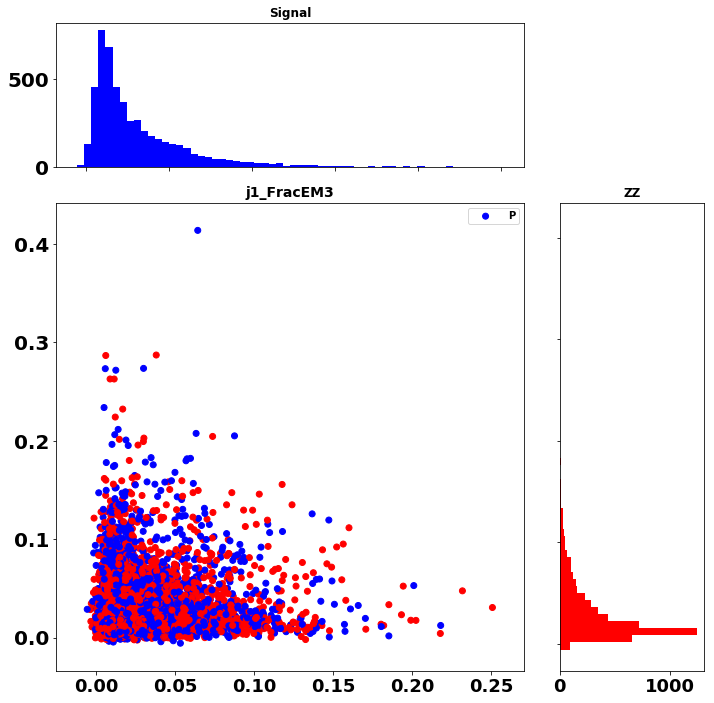

0.0127679814847


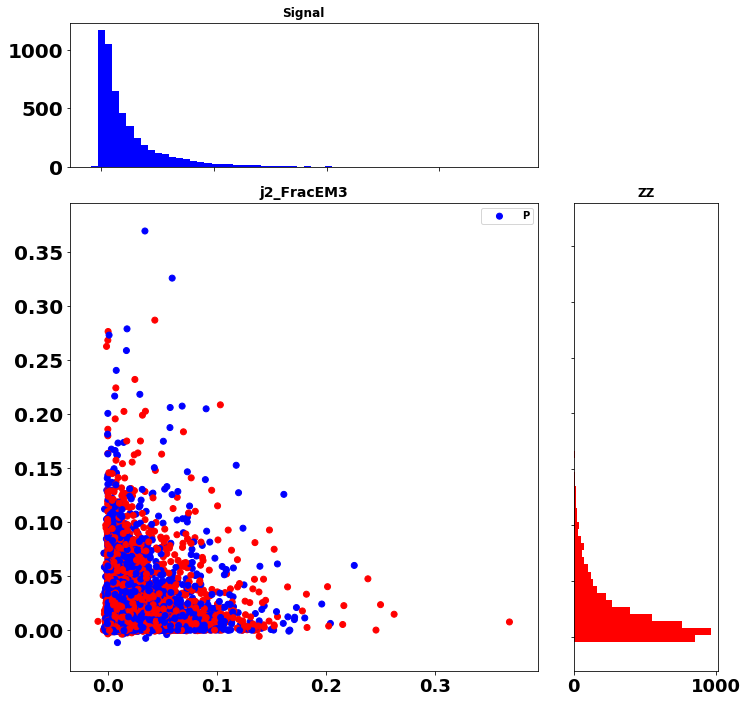

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from numpy import *
from matplotlib.patches import Rectangle

# the random data

variables = "j1_Ptrel,j2_Ptrel,j1_Pt,j2_Pt,j1_FracEM3,j2_FracEM3"

label=['s','t']
for variable,i in zip(variables.split(","),range(len(data[0]))):
    x = signal[:,i]
    y = ZZ [:,i]
    nullfmt = NullFormatter()         # no labels

# definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.05

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
    plt.figure(1, figsize=(10, 10))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

# no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
    
    axScatter.scatter(x, y,c=['b','r'])
    axScatter.set_title(variable, size=14, weight='bold')
    

# now determine nice limits by hand:
    #binwidth = 0.25
    #xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #axScatter.set_xlim((-lim, lim))
    #axScatter.set_ylim((-lim, lim))

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    
    axHistx.hist(x, 60, color='b')
    
    axHistx.set_title('Signal', size=12, weight='bold')
    #axHistx.set_xlabel(variable, size=10, weight='bold')
    #axHistx.set_ylabel("Frequency", size=10, weight='bold')
    
    
    axHisty.hist(y, 60, color='r', orientation='horizontal')

    axHisty.set_title('ZZ', size=12, weight='bold')
    #axHisty.set_ylabel(variable, size=10, weight='bold')
    #axHisty.set_xlabel("Frequency", size=10, weight='bold')
    
    #axHistx.set_xlim(axScatter.get_xlim())
    #axHisty.set_ylim(axScatter.get_ylim())
    
    pearson = np.corrcoef(x,y)[1,0]
    print pearson
    axScatter.legend("Pearson Coeficient = "+str(round(pearson,5)))

    plt.show()
    

In [3]:
#Train a Classifier                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils

from sklearn import cross_validation
from sklearn import preprocessing

n_folds = 2
n_inits = 2
norm = 'mapstd'

CVO = cross_validation.StratifiedKFold(trgt,n_folds)
CVO = list(CVO)

classifiers = {}

#SGD parameters

lr=0.001 
#decay=1e-5
decay=lr/100
momentum=0.9


for ifold in range(n_folds):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if norm == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data[train_id,:])
    elif norm == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data[train_id,:])
    elif norm == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
    norm_data = scaler.transform(data)
    
    best_init = 0
    best_loss = 999
    
    for i_init in range(n_inits):
        print ('Processing: Fold %i of %i Init %i of %i'%(
                ifold+1, n_folds, 
                i_init+1, n_inits))
        model = Sequential()
        model.add(Dense(data.shape[1],
                        input_dim=data.shape[1],
                        init='identity',
                        trainable=False))
        model.add(Activation('linear'))
        model.add(Dense(100, input_dim=data.shape[1], 
                        init='uniform'))
        model.add(Activation('tanh'))
        model.add(Dense(2,
                        init='uniform')) 
        model.add(Activation('tanh'))
        
        sgd = SGD(lr, decay, momentum)
        model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=25, 
                                                verbose=0, 
                                                mode='auto')
        # Train model
        init_trn_desc = model.fit(norm_data[train_id], 
                                  sparse_trgt[train_id], 
                                  nb_epoch=200, 
                                  batch_size=50, 
                                  callbacks=[earlyStopping], 
                                  verbose=True, 
                                  validation_data=(norm_data[test_id],
                                                   sparse_trgt[test_id]), 
                                  shuffle=True)
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifiers[ifold] = model

/home/isabella/.virtualenvs/pt_rel_analysis/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Processing: Fold 1 of 2 Init 1 of 2
Train on 5000 samples, validate on 5000 samples
Epoch 1/200
5000/5000 [==============================] - 0s - loss: 1.7340 - acc: 0.4997 - val_loss: 0.7940 - val_acc: 0.4992
Epoch 2/200
5000/5000 [==============================] - 0s - loss: 0.6989 - acc: 0.5461 - val_loss: 0.6788 - val_acc: 0.5675
Epoch 3/200
5000/5000 [==============================] - 0s - loss: 0.6869 - acc: 0.5657 - val_loss: 0.6805 - val_acc: 0.5677
Epoch 4/200
5000/5000 [==============================] - 0s - loss: 0.6803 - acc: 0.5652 - val_loss: 0.6733 - val_acc: 0.5786

(10000,)


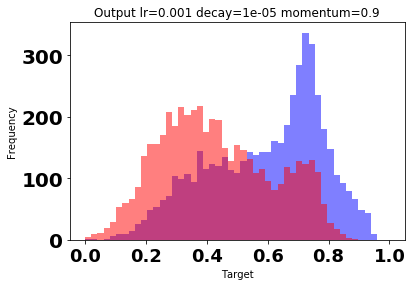

In [4]:
# analyse train process - output distribution
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

save_point = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results/"

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
output_class = np.argmax(output,axis=1)

my_bins = np.linspace(0,1, 50)
print output_class.shape
plt.hist(output[trgt==1,1],bins=my_bins,color='b',alpha=0.5)
plt.hist(output[trgt==0,1],bins=my_bins,color='r',alpha=0.5)
plt.title('Output lr='+str(lr)+' decay='+str(decay)+' momentum='+str(momentum))
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.savefig(save_point+'/'+'Output_ZZ_'+str(lr)+'_'+str(decay)+'_'+str(momentum)+'.pdf')
plt.show()


#n_rows = trgt.shape[1]
#n_columns = output.shape[1]

#fig, ax = plt.subplots(figsize=(20,20),nrows=n_rows, ncols=n_columns)
#m_bins = np.linspace(-1., 1., 50)


#irow = 0
#icolumn = 0
#for itarget in range(trgt_sparse.shape[1]):
#    for ioutput in range(output.shape[1]):
#        m_pts = output[trgt==itarget,ioutput]
#        n, bins, patches = (ax[irow,icolumn].hist(m_pts,bins=m_bins,
                                                      #fc=iris_colors[itarget],
                                                      #alpha=0.8, normed=1))
#        for tick in ax[irow,icolumn].get_xticklabels():
#            tick.set_rotation(45)
#        ax[irow,icolumn].grid()
    
#        if irow == 0:
#            ax[irow,icolumn].set_title('Output for Neuron %i'%(ioutput+1),
#                                       fontweight='bold',fontsize=15)
#        if icolumn == 0:
#            ax[irow,icolumn].set_ylabel('Class %s'%(iris_labels[itarget]),
#                                        fontweight='bold',fontsize=15)
#        if irow == n_rows-1:
#            ax[irow,icolumn].set_xlabel('Possible Values',
#                                        fontweight='bold',fontsize=15)
    
        
#        if icolumn+1 == n_columns:
#            icolumn = 0
#            irow = irow+1
#        else:
#            icolumn = icolumn+1

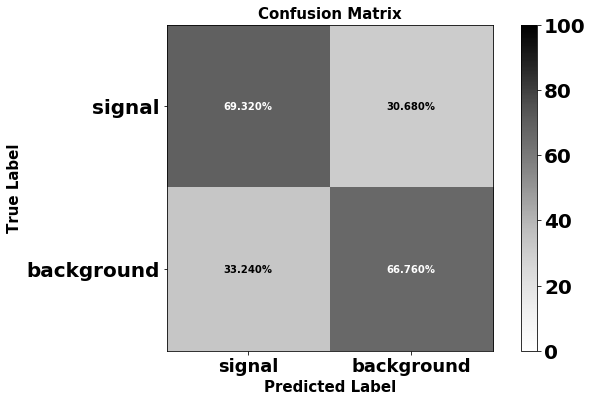

In [5]:
# analyse train process - confusion matrix
from sklearn.metrics import confusion_matrix

choose_fold = 0

train_id, test_id = CVO[choose_fold]
# normalize data based in train set
if norm == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(data[train_id,:])
elif norm == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(data[train_id,:])
elif norm == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])
        
norm_data = scaler.transform(data)

output = classifiers[choose_fold].predict(norm_data)
#output_class = np.argmax(output,axis=1)


cm = confusion_matrix(trgt[test_id], output_class[test_id], labels=[0,1])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

width, height = cm_normalized.shape


for x in xrange(width):
    for y in xrange(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(len(data_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(data_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(data_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)

fig.savefig(save_point+'/'+'Confusion_Matrix_Signal_ZZ.pdf')

In [71]:
norm_signal = scaler.transform(signal)

output_signal = classifiers[choose_fold].predict(norm_signal)
output_signal_class = np.argmax(output_signal,axis=1)

#print 'output_sinal',output_signal

(5000, 2)
[[ 0.33163652  0.68962687]
 [ 0.21107912  0.77736282]
 [ 0.09622008  0.78198802]
 ..., 
 [ 0.38479641  0.59962028]
 [ 0.35282758  0.6584599 ]
 [ 0.58298266  0.46413097]]


In [7]:
ROOT.gROOT.Reset()
ROOT.gStyle.SetOptStat(0)

In [8]:
import ROOT


# for histograms
bins = 60
m_max = 300
m_min = 0

ylabel = "Occurrences"

# Use Colors
list_color = []
list_color.append(ROOT.kBlue) # For Signal
list_color.append(ROOT.kRed) # For Bkg
list_color.append(ROOT.kGreen) # For Bkg

#  Make a list of mass histogram
list_inf_M = []

hist_inf = HistogramFunctions.OneDimHistInfo("Signal Mass ","h_lvbb_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg ZZ","h_ZZ_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)

hist_inf = HistogramFunctions.OneDimHistInfo("Bkg TTbar","h_TTbar_M",bins,m_min,m_max,"Invariant Mass",ylabel)
list_inf_M.append(hist_inf)


list_hist_M = HistogramFunctions.CreateListOf1DHistograms(list_inf_M,list_color)

c = rootnotes.canvas("c", (800, 600))

list_hist_M

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: h_lvbb_M (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: h_ZZ_M (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: h_TTbar_M (Potential memory leak).


[<ROOT.TH1F object ("h_lvbb_M") at 0x320afc0>,
 <ROOT.TH1F object ("h_ZZ_M") at 0x31e68b0>,
 <ROOT.TH1F object ("h_TTbar_M") at 0x3208a70>]

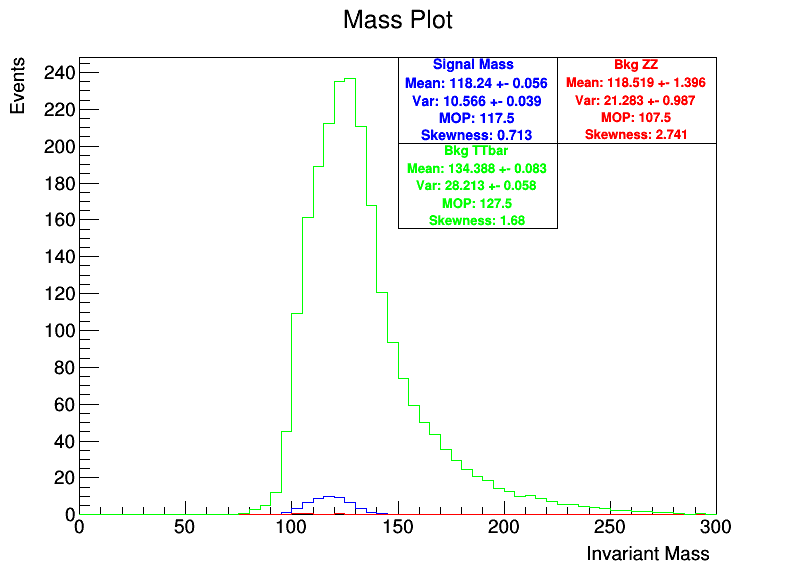

In [9]:
from sklearn.externals import joblib
#Use ROOT in order to create a numpy array with selected variables


#processes = "lvbb125,TTbar,Wbb,Wbl,Wll,Wcl,Wcc,WW,WZ,ZZ"
processes = "lvbb125,ZZ,TTbar"
output_path = "/home/isabella/Workspace/python/PtRelAnalysis/PtRelAnalysis/Results"

data_path = "/home/isabella/Workspace/Adrian2015/Public/WH/output/local/readPaul_1_0_J1Pt45+2BTag+TruthGENWZ+Clean_1_perevent+perjet"

for process in processes.split(","):
    data_input = data_path+"/"+process+".root"
    treeName = "perevent"
    file = ROOT.TFile(data_input,"READ")
    tree = file.Get(treeName)
    nrEvents = tree.GetEntries()
    #nrEvents = 4999

    for (i,entry) in enumerate(tree):
        if nrEvents>0:
            if i>nrEvents:
                break
                
        #=============================================================================
        #=======================EMJESGSCMu========================================
        # variables for EMJESGSCMu j1.     
        E1_EMJESGSCMu = tree.j1_EMJESGSCMu_E
        Phi1_EMJESGSCMu = tree.j1_EMJESGSCMu_Phi
        Eta1_EMJESGSCMu = tree.j1_EMJESGSCMu_Eta
        Pt1_EMJESGSCMu = tree.j1_EMJESGSCMu_Pt
    
        # variables for EMJESGSCMu j2.     
        E2_EMJESGSCMu = tree.j2_EMJESGSCMu_E
        Phi2_EMJESGSCMu = tree.j2_EMJESGSCMu_Phi
        Eta2_EMJESGSCMu = tree.j2_EMJESGSCMu_Eta
        Pt2_EMJESGSCMu = tree.j2_EMJESGSCMu_Pt
    
        # PtRel in EMJESGSCMu
        Theta1_EMJESGSCMu = AuxiliarFunctions.theta(Eta1_EMJESGSCMu)
        Comp1_EMJESGSCMu = AuxiliarFunctions.Componets(E1_EMJESGSCMu,Eta1_EMJESGSCMu,Phi1_EMJESGSCMu,Theta1_EMJESGSCMu)
        norm1_EMJESGSCMu = AuxiliarFunctions.norm(Comp1_EMJESGSCMu)
    
        Theta2_EMJESGSCMu = AuxiliarFunctions.theta(Eta2_EMJESGSCMu)
        Comp2_EMJESGSCMu = AuxiliarFunctions.Componets(E2_EMJESGSCMu,Eta2_EMJESGSCMu,Phi2_EMJESGSCMu,Theta2_EMJESGSCMu)
        norm2_EMJESGCMu = AuxiliarFunctions.norm(Comp2_EMJESGSCMu)
    
        # sum of components.
        Comp3_EMJESGSCMu = AuxiliarFunctions.somaComponents(Comp1_EMJESGSCMu,Comp2_EMJESGSCMu)
        norm3_EMJESGSCMu = AuxiliarFunctions.norm(Comp3_EMJESGSCMu)
        numerador1_EMJESGSCMu = AuxiliarFunctions.numerador(Comp1_EMJESGSCMu,Comp3_EMJESGSCMu)    
        angle1_EMJESGSCMu = AuxiliarFunctions.alpha(numerador1_EMJESGSCMu,norm1_EMJESGSCMu,norm3_EMJESGSCMu)
    
        #compute Relative Pt
        PtRel_j1_EMJESGSCMu = AuxiliarFunctions.PtRelative(E1_EMJESGSCMu,angle1_EMJESGSCMu)
    
        #==========================
        #==========================
    
        # only for EM and j1.
        
        j1_FracEM3 = tree.j1_FracEM3
        
        # only for EM and j2.
        
        j2_FracEM3 = tree.j2_FracEM3
        
        NNinput = np.array([j1_FracEM3,Pt1_EMJESGSCMu,PtRel_j1_EMJESGSCMu,
                            j2_FracEM3,Pt2_EMJESGSCMu,PtRel_j1_EMJESGSCMu])
        
        V_NNinput = np.reshape(NNinput, (1,6))
        norm_NNinput = scaler.transform(V_NNinput)
        
        output_NN = classifiers[choose_fold].predict(norm_NNinput)
        #print i ,output_NN
        
        if output_NN[0,1]>0.6:
            
            j1_LV = ROOT.TLorentzVector()
            j2_LV = ROOT.TLorentzVector()
            
            j1_LV.SetPtEtaPhiE(Pt1_EMJESGSCMu,
                           Eta1_EMJESGSCMu, Phi1_EMJESGSCMu,E1_EMJESGSCMu)
            j2_LV.SetPtEtaPhiE(Pt2_EMJESGSCMu,
                           Eta2_EMJESGSCMu, Phi2_EMJESGSCMu,E2_EMJESGSCMu)
            
            dijet_LV = j1_LV + j2_LV
            Mass = dijet_LV.M()
            
            if process == 'lvbb125': 
                
                list_hist_M[0].Fill(Mass,tree.eventWeight)
            
            if process == 'ZZ':
                list_hist_M[1].Fill(Mass,tree.eventWeight)
            if process == 'TTbar':
                list_hist_M[2].Fill(Mass,tree.eventWeight)
                
clone_list_M = []
for hist in list_hist_M:
    newhist = hist.Clone()
    clone_list_M.append(newhist)
    
HistogramFunctions.Draw1DHists(list_hist_M,output_path)
HistogramFunctions.DrawList1DHistInCanvas(clone_list_M, "Mass Plot", " Invariant Mass ", "Events", c)        

c

In [10]:
c.Print(output_path+'/predictPlot.pdf')
print list_hist_M[0].GetEntries()
print list_hist_M[1].GetEntries()

54172.0
2837.0
